In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File importing 

Customize which analysis you want to do

## Parameters:

- model: micro, uno
- milliseconds: 10 (only micro), 50, 100, 150, 200 ms
- distance: 10, 30, 50 cm
- light: True, False

In [2]:
model = "one"
millis = 50
light = True
distance = 10

data_path = "data/"

if light == False:
    light = "_d"
else:
    light = ""
    

file_path = data_path + "arduino_" + model + \
       "/opt_s" + str(distance) + "_t" + str(millis) + light + ".log"

print(file_path)

data/arduino_one/opt_s10_t50.log


In [3]:
n_lines = 10
with open(file_path, 'r') as f:
    cnt = 0
    output = ""
    while cnt < n_lines:
        output += f.readline()
        cnt+=1
        
print(output)


26016; 54.00
26031; 54.00
26045; 54.00
26059; 54.00
26075; 54.00
26089; � 54.00
25972; 54.00
25987; 54.00
26002; 54.00



# Show the data

In [4]:
# first rows are artefacts, skipping them
skiprows=20
df = pd.read_csv(file_path, sep=';', header=None, skiprows=skiprows)
df.columns = ['t', 'y']
                    
df.head(2)

,t,y
0,2,58.0
1,3,58.0


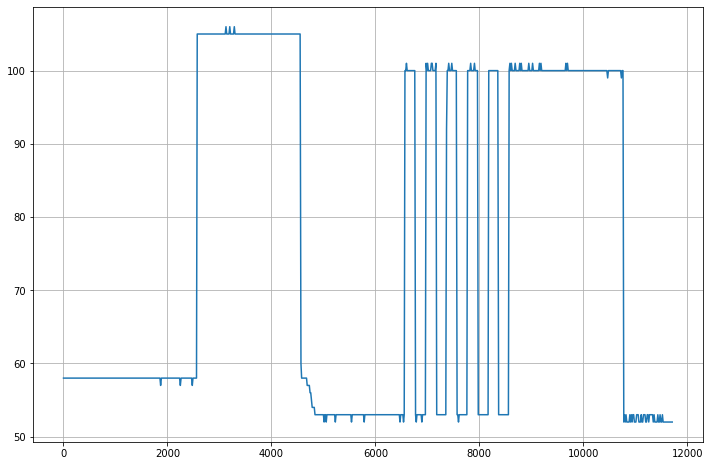

In [5]:
fig = plt.figure(figsize=(12,8))
plt.plot(df.t, df.y)
plt.grid()
plt.show()

# Simulating the receiving algorithm

In [6]:
import numpy as np

rest_state = True
configuration_state = False
loiter_state = False
receiving_state = False
conclusion_state = False

zero_setting_time = df["t"][0] + 1000
zero_list = df[df["t"] <= zero_setting_time]
nominal_zero = np.mean(zero_list)["y"]
zero_thr = 2*nominal_zero

df_real_time = df[df["t"] > zero_setting_time]
df_real_time.reset_index(inplace = True)
ratio = 0.5
cumulative_mean = nominal_zero
loiter_t = 2000
signal_delta = millis

message = ""
final_message = ""

debug = False

for i in range(0, len(df_real_time)):
    
    y = df_real_time["y"][i]
    t = df_real_time["t"][i]
    
    if rest_state:
        if debug: print("rest state", y, t)
        if y > zero_thr:
            thr = zero_thr
            configuration_state = True
            rest_state = False

    if configuration_state:
        if debug: print("configuration state", y, t, thr, cumulative_mean)
        if y < thr:
            loiter_state = True
            configuration_state = False
            loiter_start = t
        if configuration_state:
            cumulative_mean = (y + cumulative_mean)/2
            thr = cumulative_mean*ratio
        
    if loiter_state:
        if debug: print("loiter state", y, t)
        if t >= loiter_start + loiter_t:
            loiter_state = False
            receiving_state = True
            t_0 = t
            cnt = 1
            n_peaks = 0
            n_gaps = 0
    
    if receiving_state:
        if debug: print("receiving state", y, t, t_0)
        if y >= thr:
            n_peaks += 1
        else:
            n_gaps += 1
        if t >= t_0 + cnt*200:
            #print(n_peaks, n_gaps, t)
            cnt += 1
            if n_peaks >= n_gaps:
                message = message + "1"
            else:
                if message[-10:] == "1111111111" or message[-10:] == "0000000000":
                    message = message[:-10]
                    receiving_state = False
                    conclusion_state = True
                    break
                message = message + "0"
            n_peaks = 0
            n_gaps = 0
    
if conclusion_state:
    print("conclusion state", y, t)
    for idx in range(len(message)//4):
        n1 = 0; n0 = 0
        for bit in message[idx*4:(idx+1)*4]:
            if bit == "1":
                n1 += 1
            else:
                n0 += 1
        if n1 >= n0:
            final_message = final_message + "1"
        else:
            final_message = final_message + "0"
            
    rest_state = True

In [7]:
# original
print("11110000111100001111000011110000111100001111")
print(message)

11110000111100001111000011110000111100001111



In [8]:
print("10101010101")
print(final_message)

10101010101



## Create result folder

In [9]:
import os
create_result = False
output_path = ('data/results.csv')

In [10]:
path ="data/"

filelist = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file[-3:] == "log":
            filelist.append(os.path.join(root,file))

In [11]:
def offline_results(df, millis, verbose=False):
    rest_state = True
    configuration_state = False
    loiter_state = False
    receiving_state = False
    conclusion_state = False

    zero_setting_time = df["t"][0] + 1000
    zero_list = df[df["t"] <= zero_setting_time]
    nominal_zero = np.mean(zero_list)["y"]
    zero_thr = 2*nominal_zero

    df_real_time = df[df["t"] > zero_setting_time]
    df_real_time.reset_index(inplace = True)
    ratio = 0.5
    cumulative_mean = nominal_zero
    loiter_t = 2000
    signal_delta = millis

    message = ""
    final_message = ""

    debug = False

    for i in range(0, len(df_real_time)):

        y = df_real_time["y"][i]
        t = df_real_time["t"][i]

        if rest_state:
            if debug: print("rest state", y, t)
            if y > zero_thr:
                thr = zero_thr
                configuration_state = True
                rest_state = False

        if configuration_state:
            if debug: print("configuration state", y, t, thr, cumulative_mean)
            if y < thr:
                loiter_state = True
                configuration_state = False
                loiter_start = t
            if configuration_state:
                cumulative_mean = (y + cumulative_mean)/2
                thr = cumulative_mean*ratio

        if loiter_state:
            if debug: print("loiter state", y, t)
            if t >= loiter_start + loiter_t:
                loiter_state = False
                receiving_state = True
                t_0 = t
                cnt = 1
                n_peaks = 0
                n_gaps = 0

        if receiving_state:
            if debug: print("receiving state", y, t, t_0)
            if y >= thr:
                n_peaks += 1
            else:
                n_gaps += 1
            if t >= t_0 + cnt*200:
                #print(n_peaks, n_gaps, t)
                cnt += 1
                if n_peaks >= n_gaps:
                    message = message + "1"
                else:
                    if message[-10:] == "1111111111" or message[-10:] == "0000000000":
                        message = message[:-10]
                        receiving_state = False
                        conclusion_state = True
                        break
                    message = message + "0"
                n_peaks = 0
                n_gaps = 0

    if conclusion_state:
        if verbose==True: print("conclusion state", y, t)
        for idx in range(len(message)//4):
            n1 = 0; n0 = 0
            for bit in message[idx*4:(idx+1)*4]:
                if bit == "1":
                    n1 += 1
                else:
                    n0 += 1
            if n1 >= n0:
                final_message = final_message + "1"
            else:
                final_message = final_message + "0"

        rest_state = True
        
    return message, final_message

In [12]:
def get_info(file):
    
    model = file.split('/')[1].split('_')[1]
    distance = int(file.split('/')[2].split('_')[1].split('s')[1])
    
    # if there is no d
    if len(file.split('/')[2].split('_')) == 4:
        # in the darkness
        light = False
        
        # take delta_t 
        millis = file.split('/')[2].split('_')[2].split('t')[1].split('.')[0]
    else:
        # in the light
        light = True
        
        # take millis
        millis = file.split('/')[2].split('_')[2].split('t')[1].split('.')[0]
        
    millis = int(millis)
    
    return model, distance, millis, light

In [13]:
if create_result:
    res = []
    
    for file in filelist:
        
        model, distance, millis, light = get_info(file)
        skiprows=20

        try:
            df = pd.read_csv(file, sep=';', header=None, skiprows=skiprows)
            df.columns = ['t', 'y']
            message, final_message = offline_results(df, millis, verbose=False)
            
            res.append([file.split('/')[2], model, 
                        distance, millis, light,
                        message, str(final_message)])
        except:
            print('error in file <{}>'.format(file))
            
        
    df = pd.DataFrame(res)
    df.columns = ['file', 'model', 'cm', 'ms', 'light', 'message', 'final_message']
    df.to_csv(output_path, index=False)

error in file <data/arduino_micro/opt_s50_t200_d.log>
error in file <data/arduino_micro/opt_s30_t200.log>
error in file <data/arduino_micro/opt_s10_t50.log>
error in file <data/arduino_one/opt_s30_t200_d.log>
error in file <data/arduino_one/opt_s30_t100.log>


In [14]:
pd.read_csv(output_path)

,file,model,cm,ms,light,message,final_message
0,opt_s30_t200_d.log,micro,30,200,False,11110000111100001111000011110000111100001111,1.010101e+10
1,opt_s50_t50.log,micro,50,50,True,NaN,NaN
2,opt_s50_t100_d.log,micro,50,100,False,1100110011001100110011,1.111100e+04
3,opt_s10_t200.log,micro,10,200,True,11110000111100001111000011110000111100001111,1.010101e+10
4,opt_s50_t50_d.log,micro,50,50,False,10101010101,1.100000e+01
5,opt_s30_t150.log,micro,30,150,True,111000111000111000111000111000111,1.101101e+07
6,opt_s10_t10.log,micro,10,10,True,10,NaN
7,opt_s30_t100_d.log,micro,30,100,False,1100110011001100110011,1.111100e+04
8,opt_s10_t100.log,micro,10,100,True,1100110011001100110011,1.111100e+04
9,opt_s50_t150.log,micro,50,150,True,111000111000111000111000111000111,1.101101e+07


In [15]:
df[df.light==False]

,file,model,cm,ms,light,message,final_message
0,opt_s30_t200_d.log,micro,30,200,False,11110000111100001111000011110000111100001111,10101010101
2,opt_s50_t100_d.log,micro,50,100,False,1100110011001100110011,11111
4,opt_s50_t50_d.log,micro,50,50,False,10101010101,11
7,opt_s30_t100_d.log,micro,30,100,False,1100110011001100110011,11111
10,opt_s10_t150_d.log,micro,10,150,False,111000111000111000111000111000111,11011011
13,opt_s10_t100_d.log,micro,10,100,False,1100110011001100110011,11111
14,opt_s30_t150_d.log,micro,30,150,False,111000111000111000111000111000111,11011011
15,opt_s10_t50_d.log,micro,10,50,False,10101010101,11
18,opt_s10_t200_d.log,micro,10,200,False,11110000111100001111000011110000111100001111,10101010101
19,opt_s10_t10_d.log,micro,10,10,False,10,
